In [1]:
%matplotlib inline
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob 
import os 
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [9]:
input_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/outputs/epkm_reconstruct/epkm_all_samples/for_comparison/'
output_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/outputs/epkm_reconstruct/epkm_all_samples/supplement/'

In [3]:
polysome_file = '/home/rmarina/projects/apobec/revision_riboseq_comparison/ribosome_files/fred_x3_polysome_RPKM.txt'
riboseq_file = '/home/rmarina/projects/apobec/revision_riboseq_comparison/ribosome_files/GSE94460_RPKM.txt'

In [10]:
cds_samples = sorted(glob.glob(os.path.join(input_dir, '*_cds_only.txt')))
utr_samples = sorted(glob.glob(os.path.join(input_dir, '*_cds_3utr_only.txt')))

In [11]:
sample_prefix = []

for sample in cds_samples:
    sample_prefix.append(sample.split('_epkm')[0])

In [12]:
samples_0 = []
samples_05 = []
samples_09 = []


for x in sample_prefix:
    if '_conf0.5' in x:
        samples_05.append(x)
    elif '_conf0.9' in x:
        samples_09.append(x)
    else:
        samples_0.append(x)

In [24]:
def r2pearson(x, y):
    # Pearson correlation (R2) shortcut 
    return pearsonr(x, y)[0] ** 2

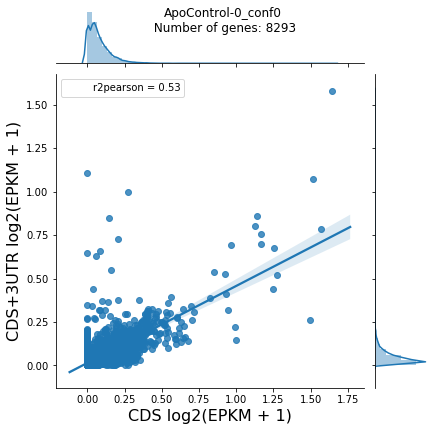

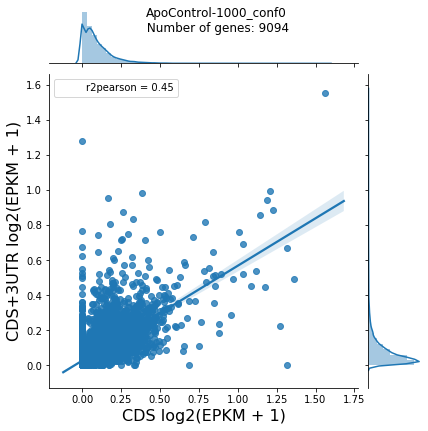

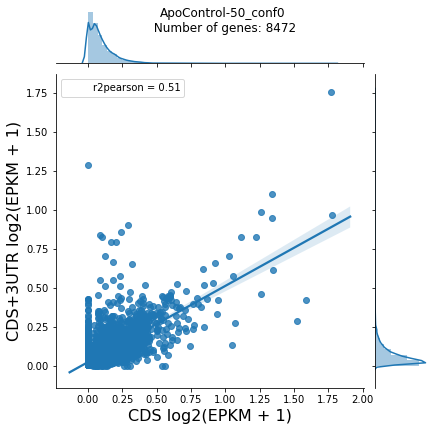

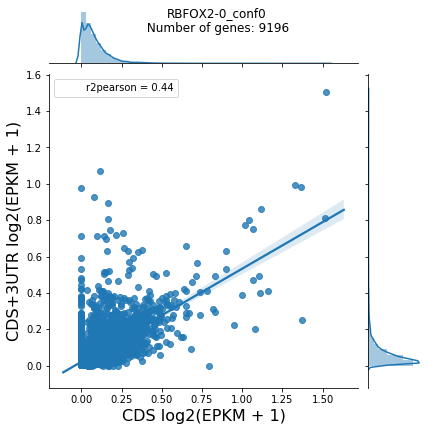

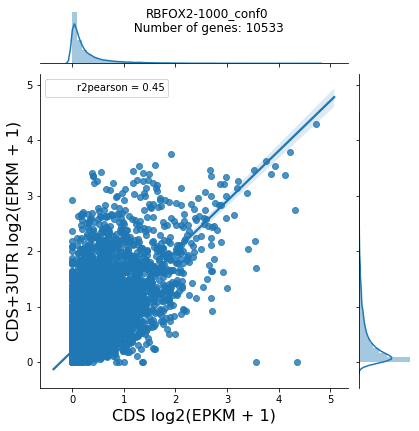

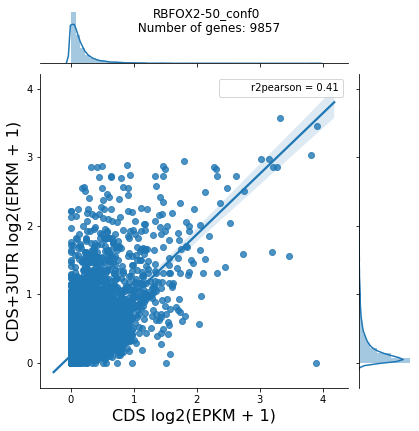

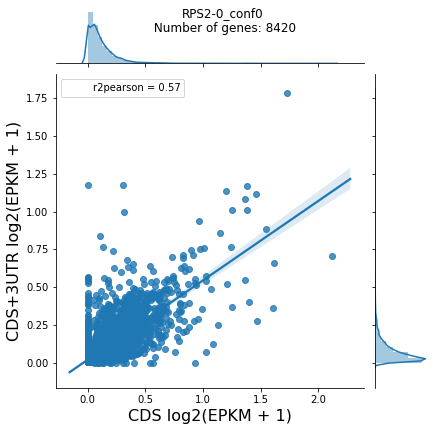

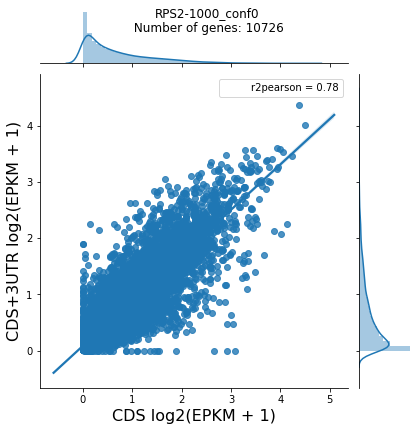

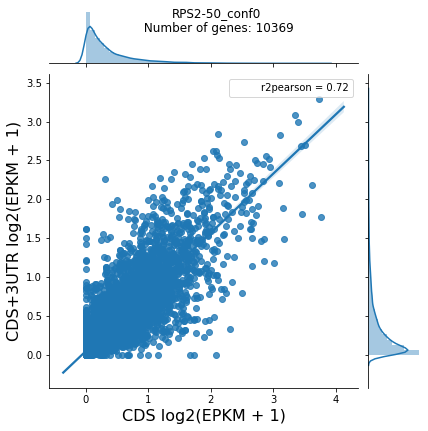

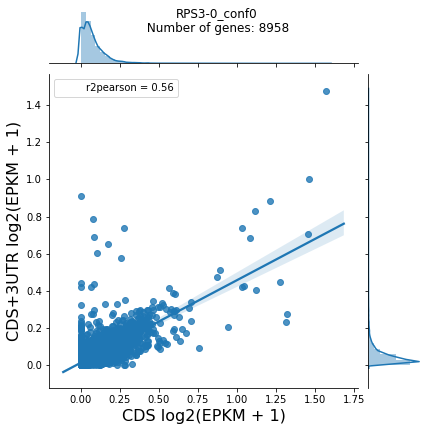

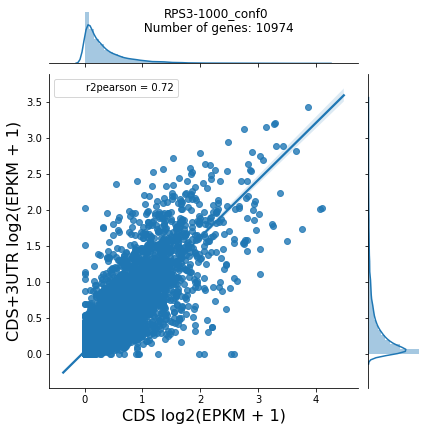

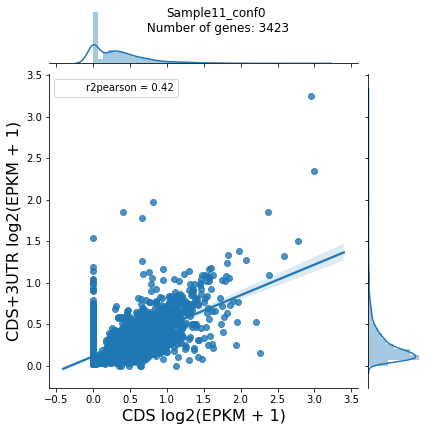

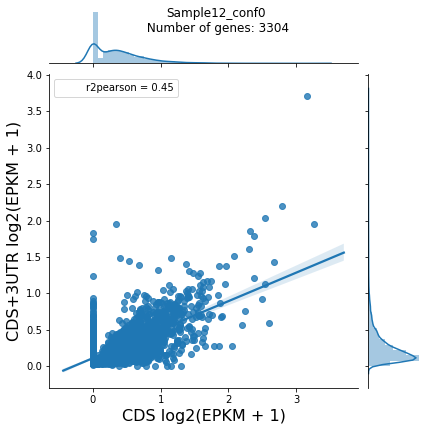

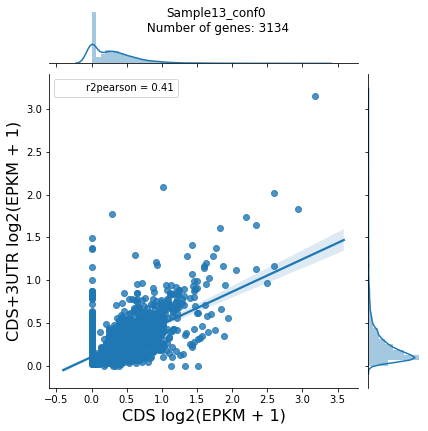

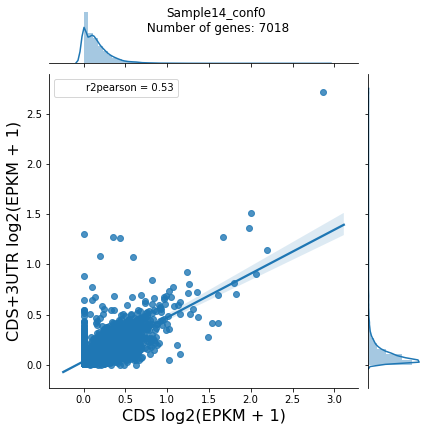

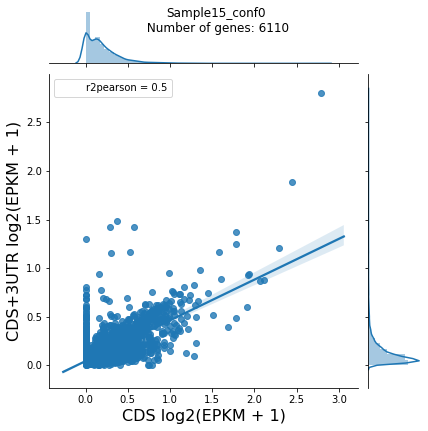

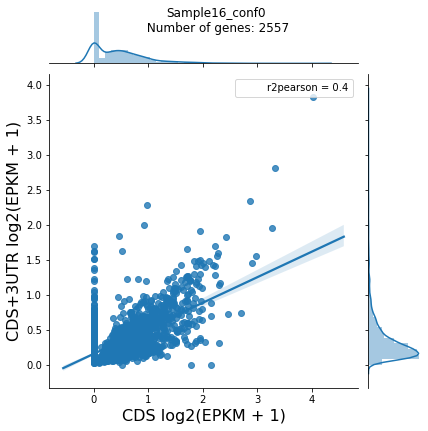

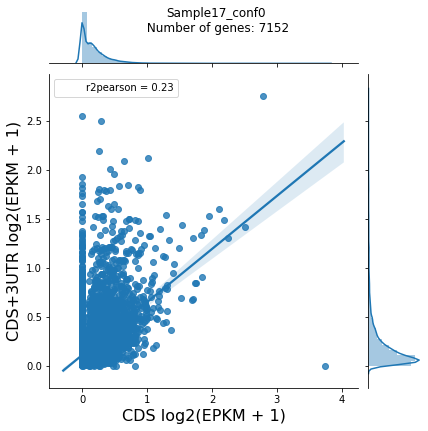

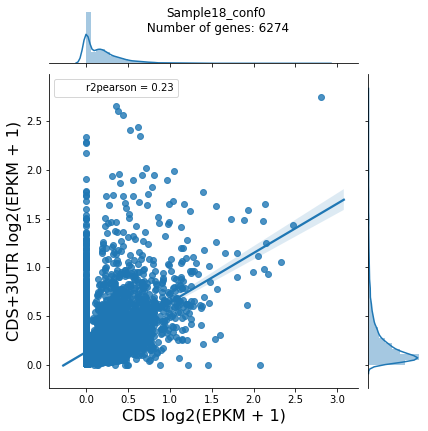

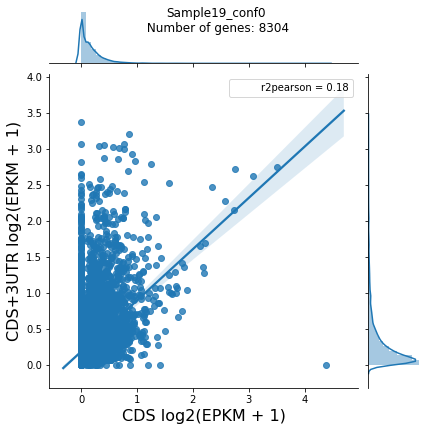

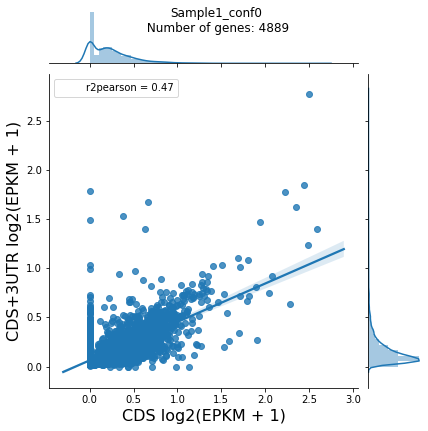

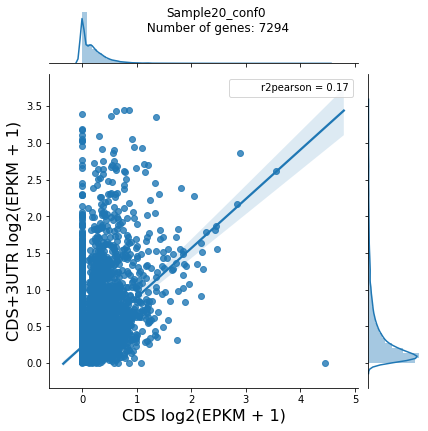

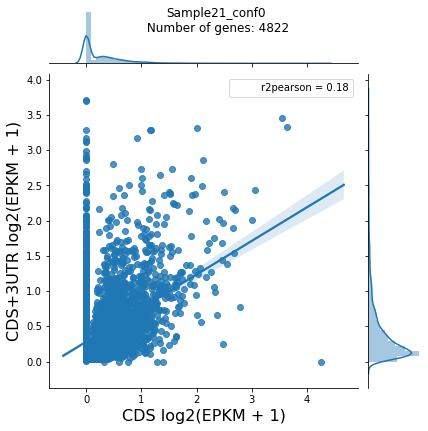

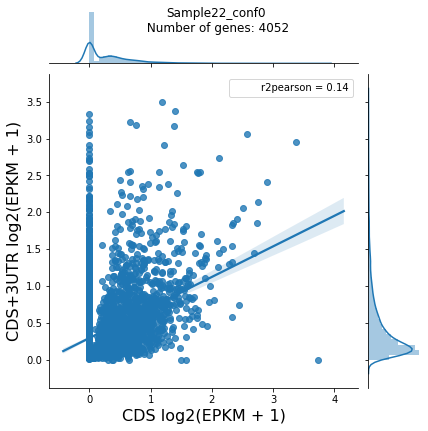

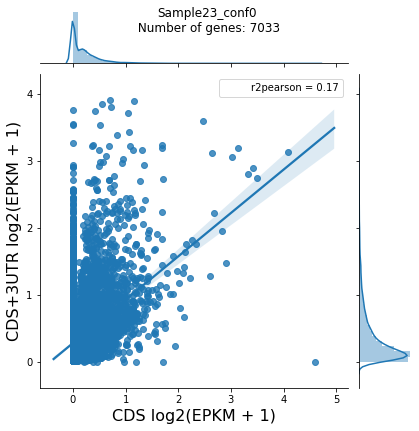

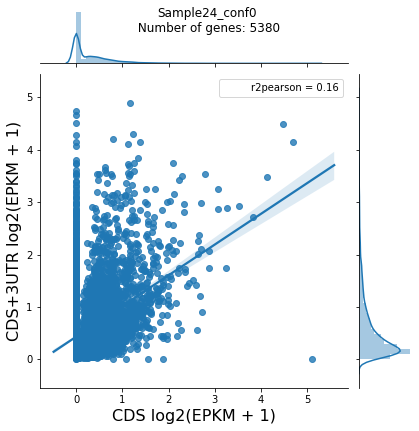

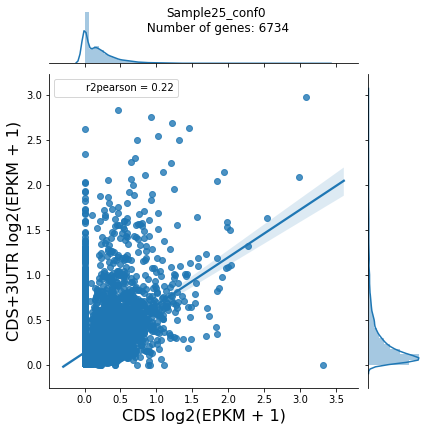

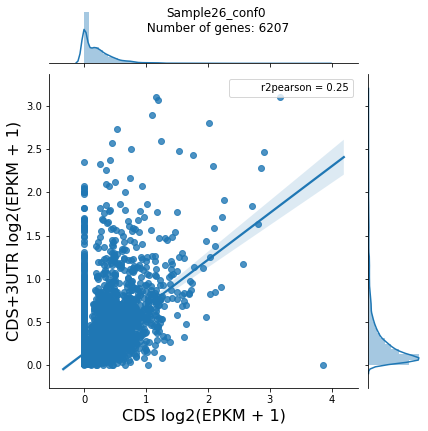

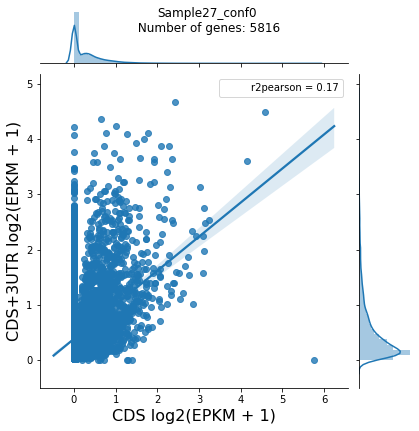

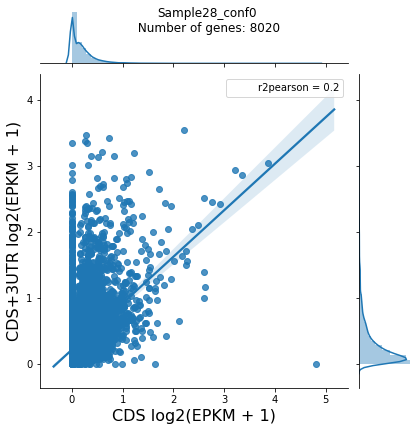

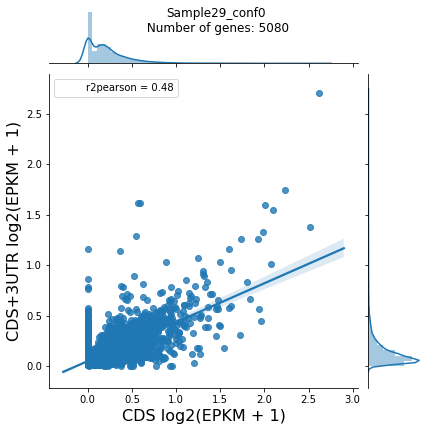

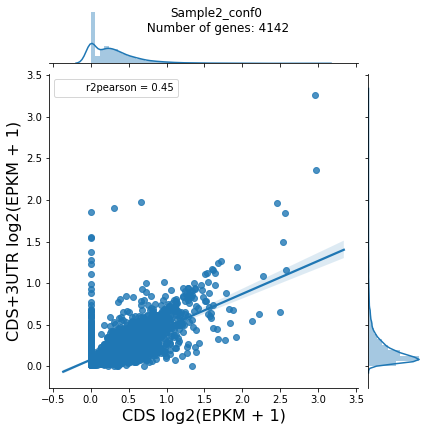

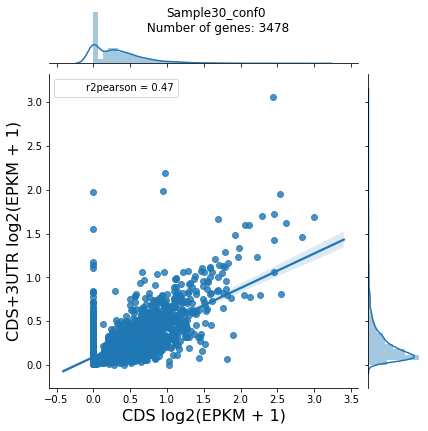

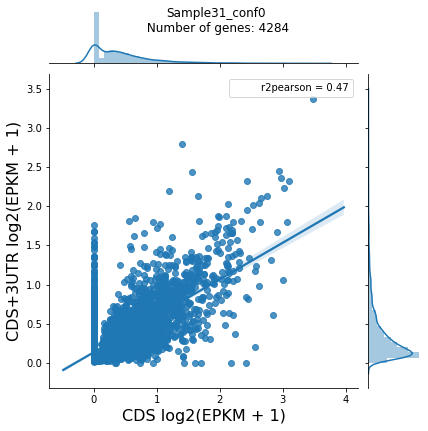

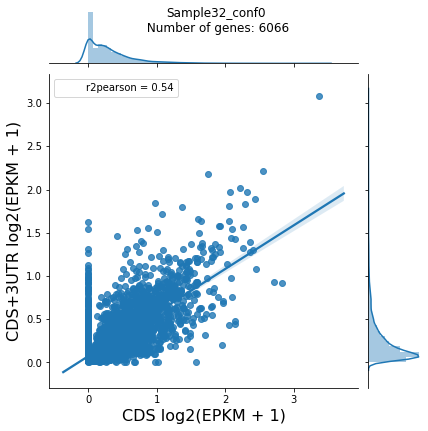

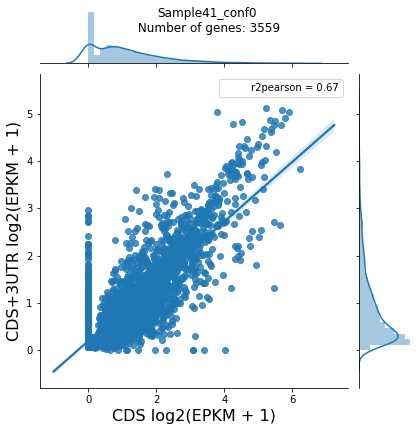

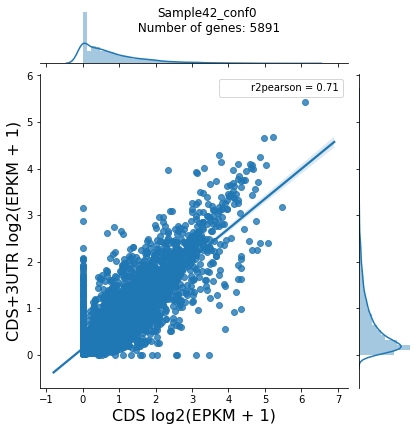

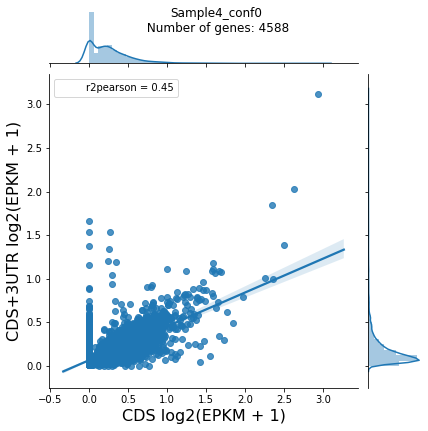

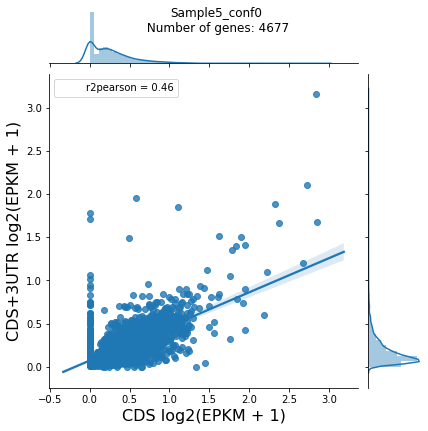

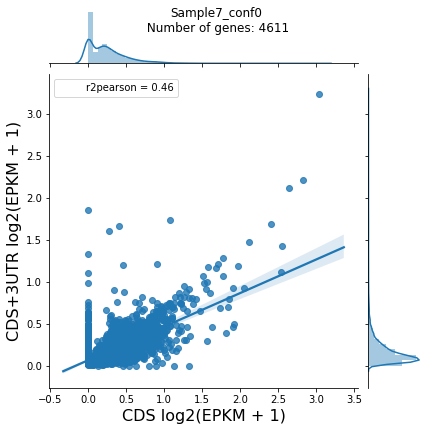

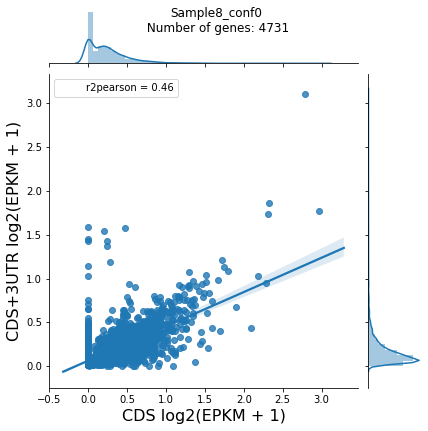

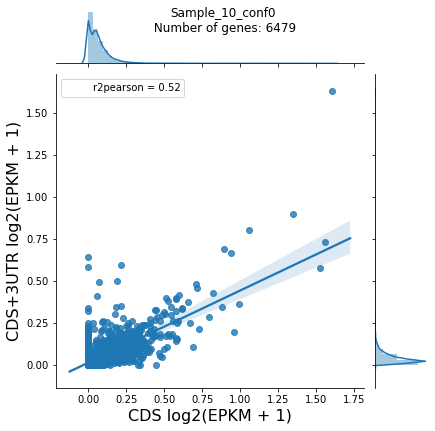

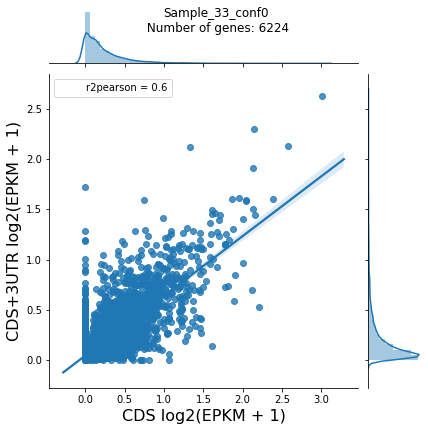

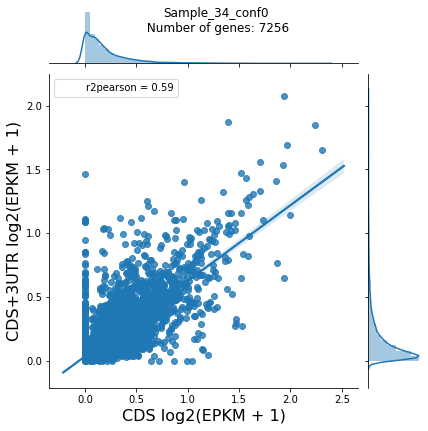

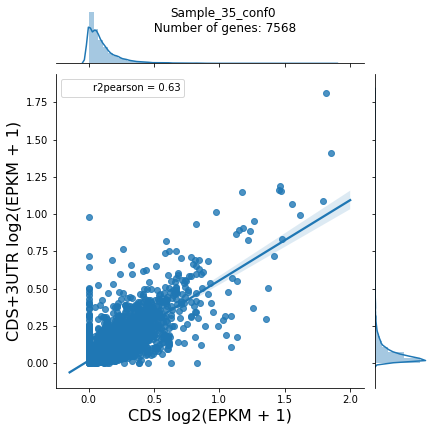

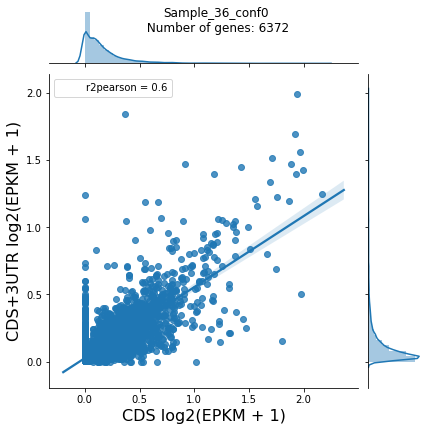

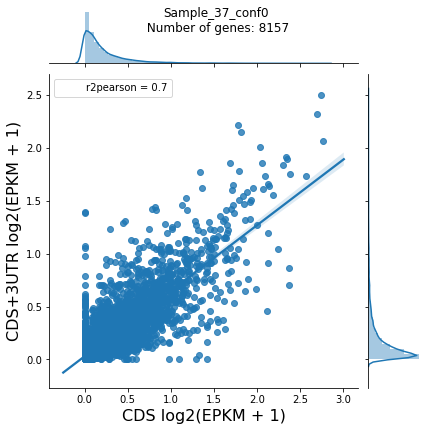

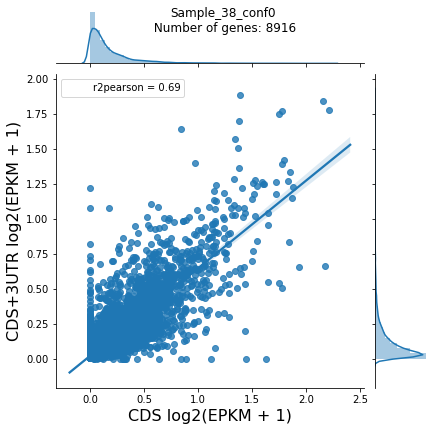

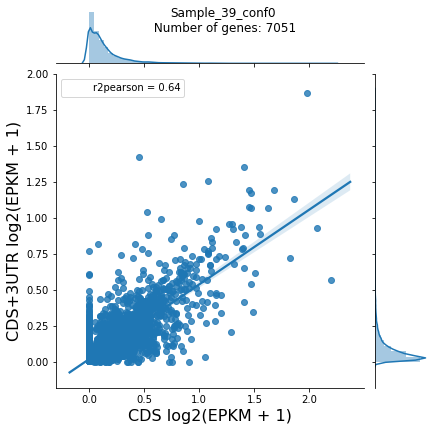

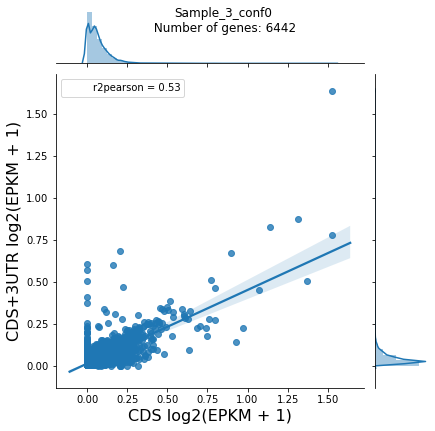

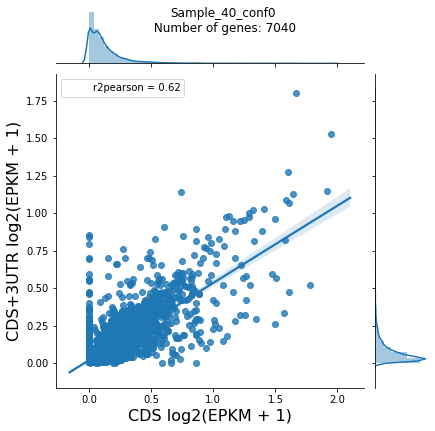

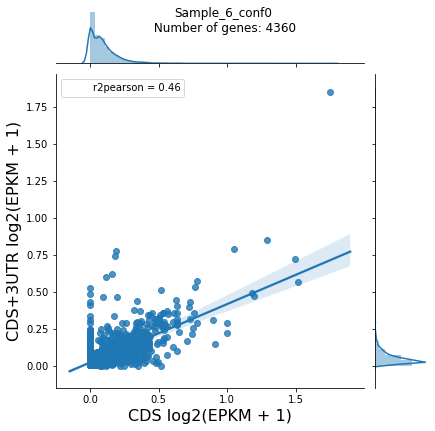

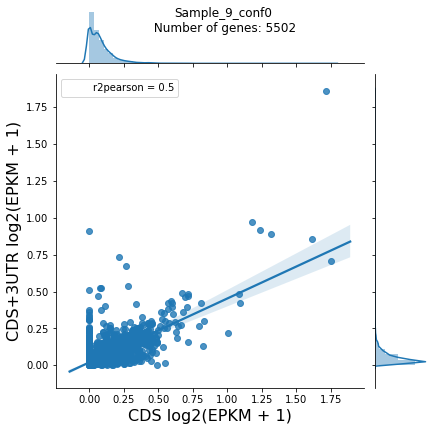

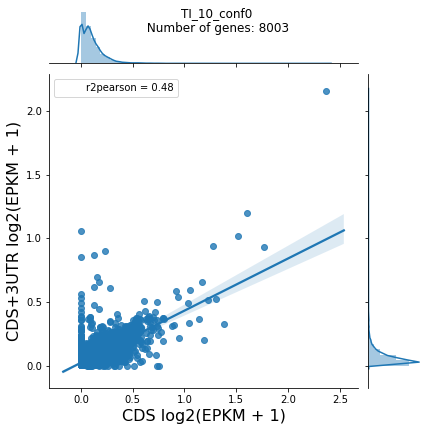

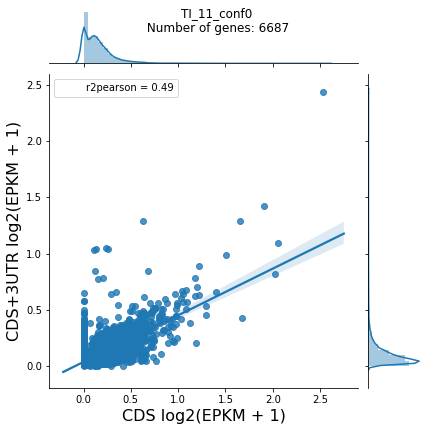

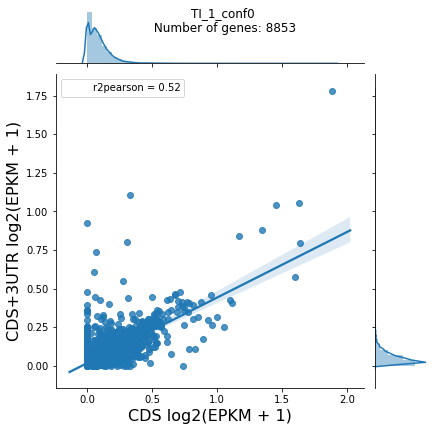

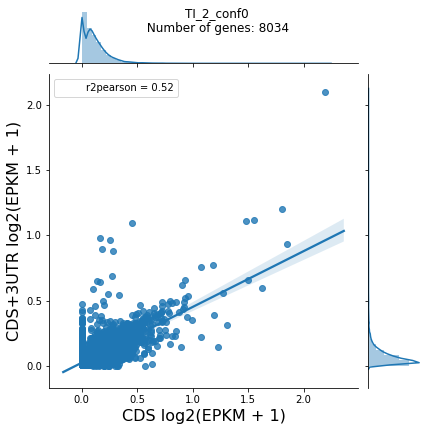

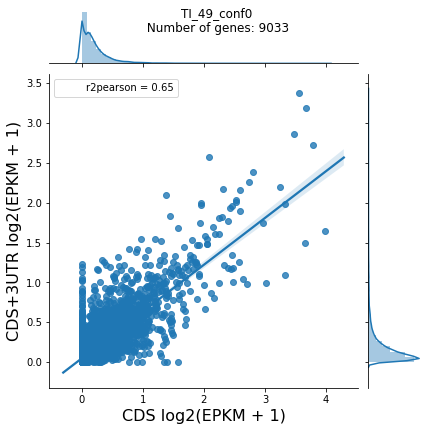

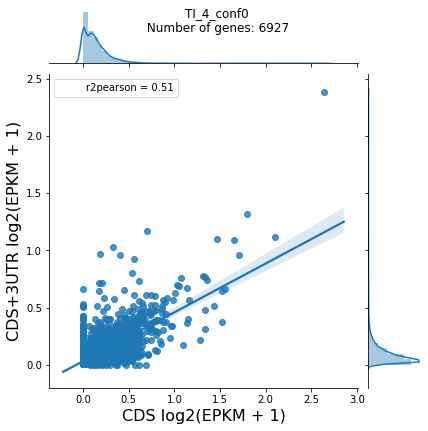

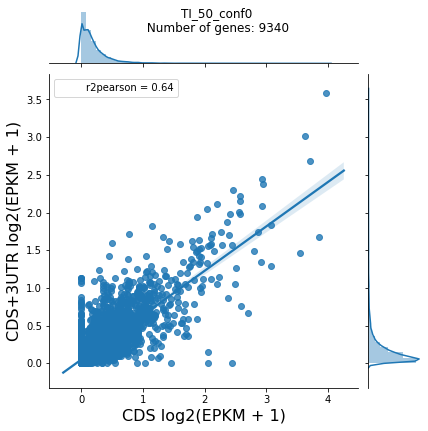

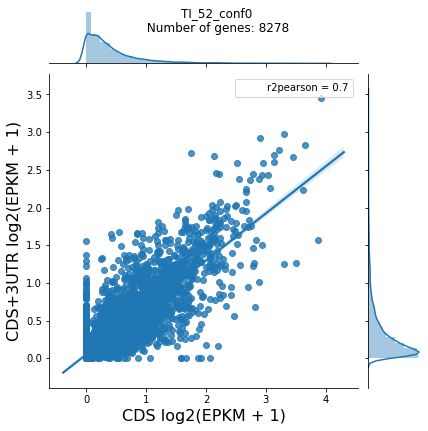

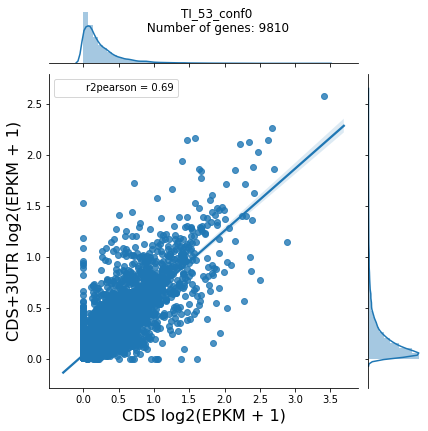

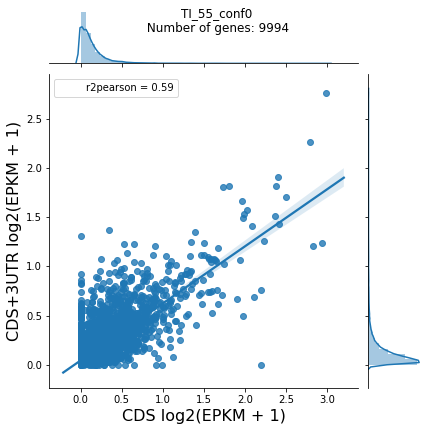

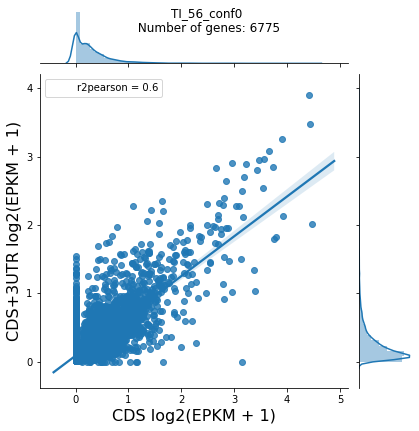

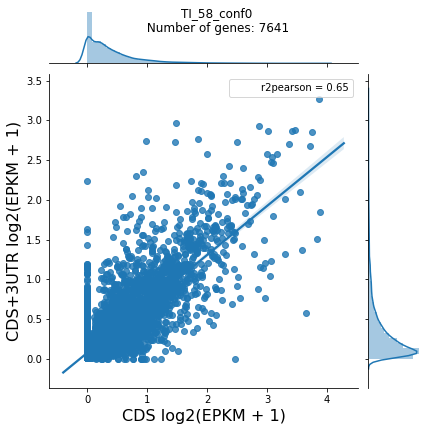

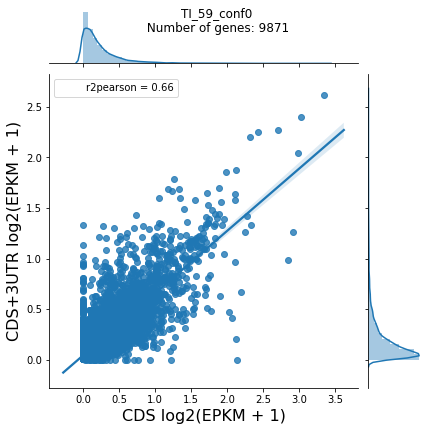

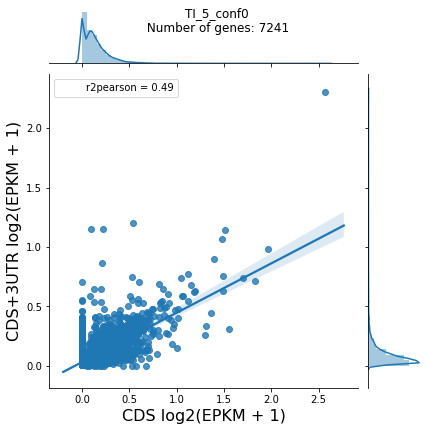

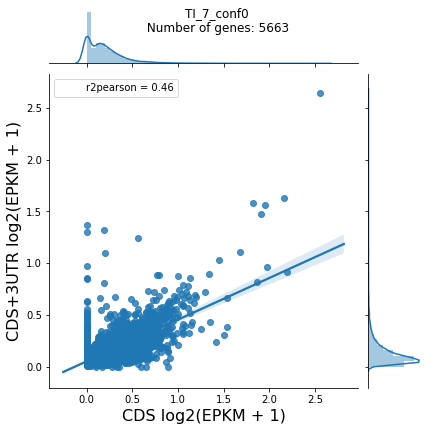

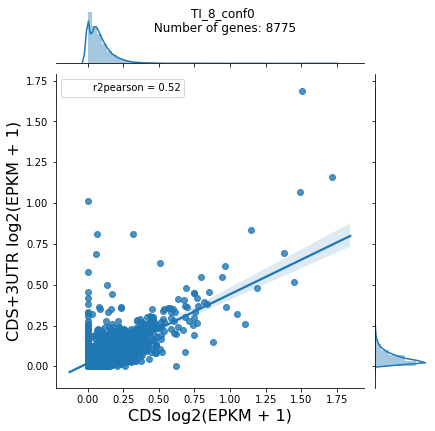

In [28]:
# Conf 0
corr_dict = {}
corr_log_dict = {}

for sample in samples_0:
    if os.path.exists(sample+'_epkm_table_cds_only.txt') & os.path.exists(sample+'_epkm_table_cds_3utr_only.txt'):
        
        cds = pd.read_csv(sample+'_epkm_table_cds_only.txt', index_col=0, sep='\t')
        exon = pd.read_csv(sample+'_epkm_table_cds_3utr_only.txt', index_col=0, sep='\t')
        
        cds_epkm = cds['EPKM']
        exon_epkm = exon['EPKM']
        
        corr_df = pd.merge(cds_epkm, exon_epkm, how='outer', left_index=True, right_index=True).fillna(0)
        corr_df = corr_df.loc[corr_df.mean(axis=1) != 0] # this is removing events that have EPKM of 0 for both. May go back and include these events 
        corr_df_log = np.log2(corr_df+1)
        
        
        sample_name = os.path.basename(sample).split('_conf')[0]
        
        PR2 = pearsonr(corr_df['EPKM_x'], corr_df['EPKM_y'])[0] ** 2
        SR2 = spearmanr(corr_df['EPKM_x'], corr_df['EPKM_y'])[0] ** 2
        
        PR2_log = pearsonr(corr_df_log['EPKM_x'], corr_df_log['EPKM_y'])[0] ** 2
        SR2_log = spearmanr(corr_df_log['EPKM_x'], corr_df_log['EPKM_y'])[0] ** 2
        
        
        corr_dict[sample_name] = [PR2, SR2]
        corr_log_dict[sample_name] = [PR2_log, SR2_log]
        
        genes = len(corr_df)
        subtitle = os.path.basename(sample)
        
        f = sns.jointplot(data=np.log2(corr_df+1),
                          x='EPKM_x',
                          y='EPKM_y',
                          kind='reg',
                          stat_func=r2pearson
                         )
        f.fig.suptitle("{}\n Number of genes: {}".format(subtitle, genes))
        f.set_axis_labels('CDS log2(EPKM + 1)', 'CDS+3UTR log2(EPKM + 1)', fontsize=16)
        f.savefig(output_dir+'{}_cds_vs_cds_plus_3utr_epkm_all_genes.pdf'.format(subtitle), bbox_inches='tight', dpi=300)
        
Samples_0 = pd.DataFrame(data=corr_dict).T
Samples_0.columns = ['Pearson_R2', 'Spearman_R2']
Samples_0.to_csv(output_dir+'sample_cds_vs_cds_3utr_conf0_corr.csv')

Samples_0_log = pd.DataFrame(data=corr_log_dict).T
Samples_0_log.columns = ['Pearson_R2', 'Spearman_R2']
Samples_0_log.to_csv(output_dir+'sample_cds_vs_cds_3utr_conf0_corr_log.csv')
